In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# invert one hot encoding
def combine_binary_columns(df):
    target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
    # the column contains as an entry the name of the column, if the value is 1, if more then 1 column is 1 then the naming is Target1_Target2
    df['Target'] = df[target_columns].apply(lambda row: '_'.join(row[row == 1].index), axis=1)
    # drop the old columns
    df = df.drop(columns=target_columns)
    # replace '' with 'None'
    df['Target'] = df['Target'].replace('', 'None')
    return df

In [3]:
# load in data
df_train = combine_binary_columns(pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e3/train.csv'))
df_test = pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e3/test.csv')

# targets are Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults
X_train = df_train.drop('Target', axis=1)
y_train = df_train['Target']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# create pipeline
model = DecisionTreeClassifier()

# fit pipeline
model.fit(X_train, y_train)

DecisionTreeClassifier()

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

                       precision    recall  f1-score   support

                Bumps       0.40      0.40      0.40       924
            Dirtiness       0.15      0.18      0.16        85
             K_Scatch       0.82      0.80      0.81       680
       K_Scatch_Bumps       0.00      0.00      0.00         2
K_Scatch_Other_Faults       0.00      0.00      0.00         0
                 None       0.04      0.03      0.03       183
         Other_Faults       0.43      0.42      0.42      1349
               Pastry       0.23      0.24      0.24       301
      Pastry_K_Scatch       0.00      0.00      0.00         0
               Stains       0.51      0.59      0.55       100
            Z_Scratch       0.38      0.43      0.40       220

             accuracy                           0.45      3844
            macro avg       0.27      0.28      0.27      3844
         weighted avg       0.45      0.45      0.45      3844



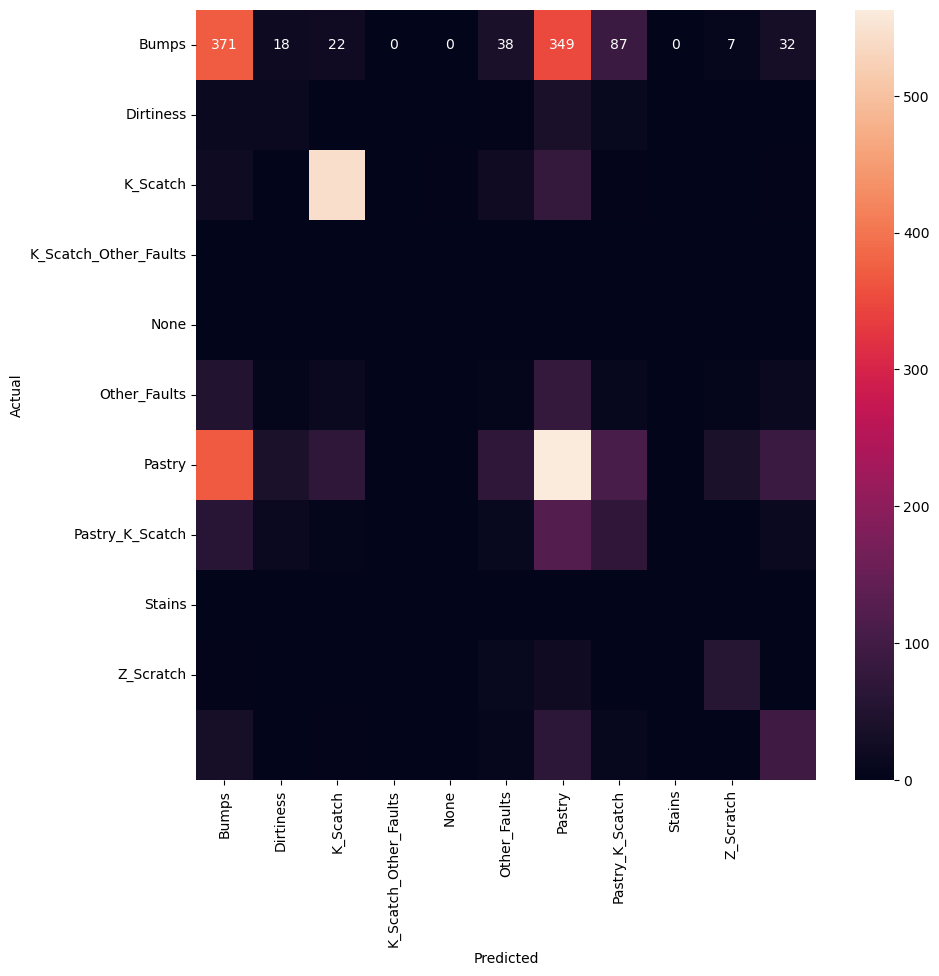

In [5]:
# predict
y_pred = model.predict(X_test)

# evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# create confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [7]:
# using optuna to optimize hyperparameters
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
def objective(trial):
    # hyperparameters to optimize
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    
    # create model
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # cross validation
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

# create study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2024-03-06 10:20:32,771] A new study created in memory with name: no-name-2b29559f-e7f7-4650-9e30-13bea9469c8a
[I 2024-03-06 10:20:33,274] Trial 0 finished with value: 0.5164878048780488 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5164878048780488.
[I 2024-03-06 10:20:33,794] Trial 1 finished with value: 0.5188943089430894 and parameters: {'max_depth': 24, 'min_samples_split': 21, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.5188943089430894.
[I 2024-03-06 10:20:34,144] Trial 2 finished with value: 0.5521951219512196 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 29}. Best is trial 2 with value: 0.5521951219512196.
[I 2024-03-06 10:20:34,737] Trial 3 finished with value: 0.5015934959349594 and parameters: {'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.5521951219512196.
[I 2024-03-06 10:20:35,155] Trial 4 finished with value: 0.

In [8]:
# best hyperparameters
best_params = study.best_params
best_params

{'max_depth': 9, 'min_samples_split': 26, 'min_samples_leaf': 29}

In [9]:
# create model with best hyperparameters
model = DecisionTreeClassifier(**best_params)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

         Bumps       0.44      0.61      0.51       924
     Dirtiness       0.19      0.11      0.14        85
      K_Scatch       0.89      0.91      0.90       680
K_Scatch_Bumps       0.00      0.00      0.00         2
          None       0.00      0.00      0.00       183
  Other_Faults       0.46      0.47      0.46      1349
        Pastry       0.51      0.09      0.15       301
        Stains       0.58      0.76      0.66       100
     Z_Scratch       0.55      0.65      0.59       220

      accuracy                           0.54      3844
     macro avg       0.40      0.40      0.38      3844
  weighted avg       0.51      0.54      0.51      3844

